# Mount Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# File Paths

In [ ]:
save_path = "/content/drive/MyDrive//CNXSIA001_LAIDS_SOURCE_CODE/Baseline 1D CNN Model Files/Models" # Model path
dataset_path =  "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/Baseline 1D CNN Model Files/Datasets"

# Load in Datasets

(and convert to numpy)

In [ ]:
import pandas as pd
import os
import numpy as np

#Encoding map
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label


# Training sets (ADASYN-resampled baseline CNN)
X_train = pd.read_csv(os.path.join(dataset_path, "adasyn_baseline_X_train.csv")).to_numpy()
y_train = pd.read_csv(os.path.join(dataset_path, "adasyn_baseline_y_train.csv")).to_numpy().ravel()

# Validation sets
X_val = pd.read_csv(os.path.join(dataset_path, "baseline_X_val.csv")).to_numpy()
y_val = pd.read_csv(os.path.join(dataset_path, "baseline_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(dataset_path, "baseline_X_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(dataset_path, "baseline_y_test.csv")).to_numpy().ravel()

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)# Reshape X_train
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)# Reshape X_val
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)# Reshape X_test

def print_class_distribution(name, y):
    classes, counts = np.unique(y, return_counts=True)
    print(f"\n{name} class distribution:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {c}: {cnt}")

print_class_distribution("y_train", y_train)
print_class_distribution("y_val", y_val)
print_class_distribution("y_test", y_test)





y_train class distribution:
  Class 0: 301688
  Class 1: 301212
  Class 2: 301702
  Class 3: 301697
  Class 4: 301715
  Class 5: 301702
  Class 6: 301889

y_val class distribution:
  Class 0: 75423
  Class 1: 14511
  Class 2: 343
  Class 3: 1464
  Class 4: 20482
  Class 5: 312
  Class 6: 30999

y_test class distribution:
  Class 0: 209506
  Class 1: 18139
  Class 2: 429
  Class 3: 1830
  Class 4: 25603
  Class 5: 389
  Class 6: 38749


# Perform Hyperparameter Tuning (Bayesian Optimisation) of 2 layer CNN model

```
Best Hyperparameters:
conv1_filters: 32
conv1_kernel_size: 2
dropout1_rate: 0.0
conv2_filters: 16
conv2_kernel_size: 3
dense_units: 64
dense_L2: 0.0
dropout2_rate: 0.5
learning_rate: 0.005
```



In [ ]:
# Install tuner
!pip install keras-tuner --quiet

In [ ]:
# --- Imports ---
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
def build_base_model(hp):
    model = Sequential()

    # First Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv1_filters', values=[8, 16, 32, 64, 128]),
        kernel_size=hp.Choice('conv1_kernel_size', values=[2, 3, 5]),
        activation='relu',
        input_shape=(52, 1) # Define input shape here
    ))

    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Choice('dropout1_rate', [0.0,0.2, 0.25, 0.3, 0.5])))

    # Second Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv2_filters', values=[8,16, 32, 64, 128]),
        kernel_size=hp.Choice('conv2_kernel_size', values=[2, 3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    # Flatten previous layers
    model.add(Flatten())

    # Dense layer with L2 regularization
    model.add(Dense(
        hp.Choice('dense_units', [8, 12, 24, 64]),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('dense_L2', [0.0, 0.001, 0.0001, 0.01]))
    ))

    # Dropout layer
    model.add(Dropout(hp.Choice('dropout2_rate', [0.0, 0.2, 0.25, 0.3, 0.5])))

    # Dense layer for multiclass classification with softmax activation
    model.add(Dense(7, activation='softmax')) # Assuming 7 classes based on the value_counts output

    # Compile
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])), #'adam', #add optimiser choices?
        loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
        metrics=['accuracy']
    )
    return model

In [ ]:
# --- Create tuner ---
tuner = kt.BayesianOptimization(
    build_base_model,
    objective= 'val_accuracy', # Find the hyperparameters that give the highest possible accuracy score on the validation set
    max_trials=10,
    directory='bayesian_tuning',
    project_name='baseline_cnn'
)

# --- Implement callback ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# --- Start tuning ---
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])

In [ ]:
# --- Display Best Variables ---
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

In [ ]:
# --- Visulise tunning results ---
import pandas as pd
import matplotlib.pyplot as plt

trials = tuner.oracle.get_best_trials(num_trials=20)
val_accuracies = [t.metrics.get_last_value('val_accuracy') for t in trials]

plt.plot(val_accuracies, marker='o')
plt.title('Validation Accuracy per Trial')
plt.xlabel('Trial')
plt.ylabel('Val Accuracy')
plt.grid(True)
plt.show()

#1D CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling1D


# Define input shape
input_shape = (X_train.shape[1],1)  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=32, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data and create feature maps
    BatchNormalization(),                                 # Normalises the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2),                            # Reduce the dimensions of the data but leaving key features

    Conv1D(filters=16, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GlobalAveragePooling1D(),                             # Convert the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.3),                                         # Randomly reset 30% of the network's neurons to further prevent overfitting
    Dense(num_classes, activation='softmax')              # Final output layer for multiclass classification
])

# Compile model
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 51, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 51, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,383 (13.21 KB)

 Trainable params: 3,287 (12.84 KB)

 Non-trainable params: 96 (384.00 B)

#Train 1D CNN

Epoch 1/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - accuracy: 0.8948 - loss: 0.2957 - val_accuracy: 0.5165 - val_loss: 3.5944
Epoch 2/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.9339 - loss: 0.1850 - val_accuracy: 0.9510 - val_loss: 0.7703
Epoch 3/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.9445 - loss: 0.1624 - val_accuracy: 0.9516 - val_loss: 0.7211
Epoch 4/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - accuracy: 0.9547 - loss: 0.1428 - val_accuracy: 0.9588 - val_loss: 0.1404
Epoch 5/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - accuracy: 0.9619 - loss: 0.1270 - val_accuracy: 0.9541 - val_loss: 0.1593
Epoch 6/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.9663 - loss: 0.1162 - val_accuracy: 0.9601 - val_loss: 0.1360
Epoch 7/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - accuracy: 0.9694 - loss: 0.1083 - val_accuracy: 0.9500 - val_loss: 0.2314
Epoch 8/20
32994/32994 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accura

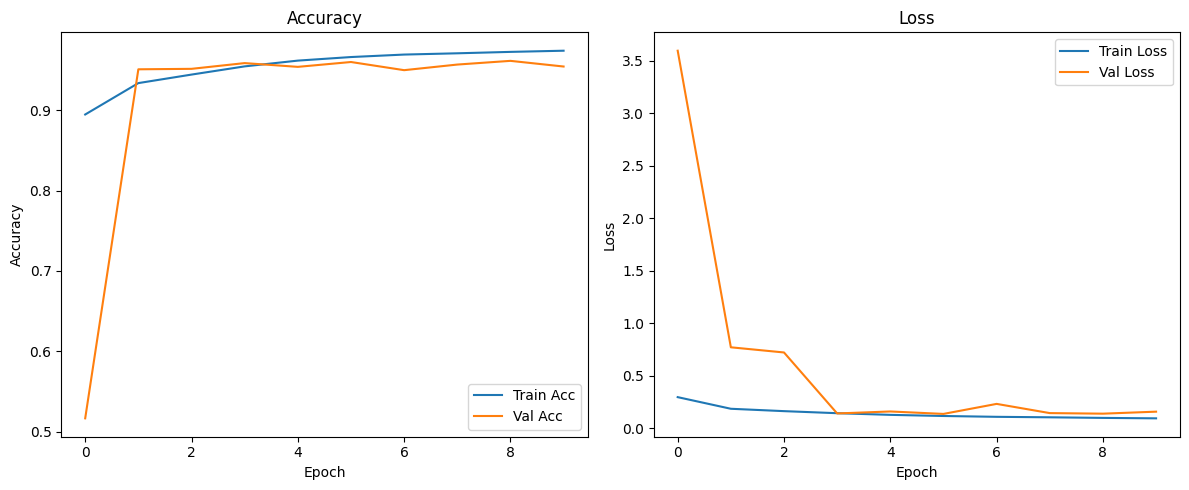

In [ ]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# --- Early-stopping ---
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=4, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss



# Train the model with early stopping
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 4s 441us/step


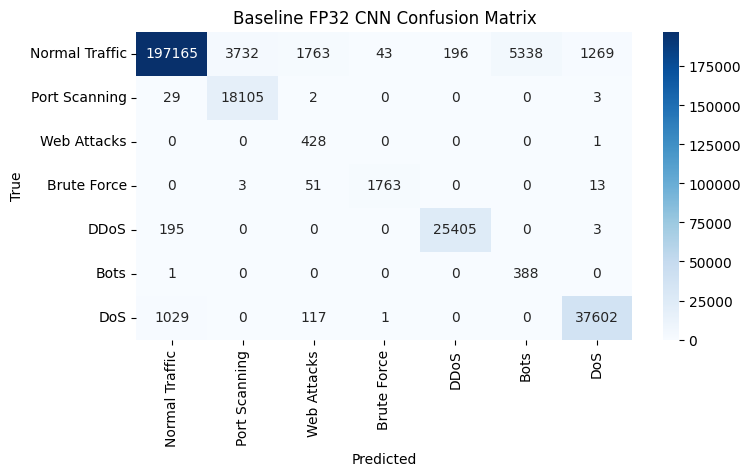

Accuracy: 0.9532013100510784
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.94      0.97    209506
 Port Scanning       0.83      1.00      0.91     18139
   Web Attacks       0.18      1.00      0.31       429
   Brute Force       0.98      0.96      0.97      1830
          DDoS       0.99      0.99      0.99     25603
          Bots       0.07      1.00      0.13       389
           DoS       0.97      0.97      0.97     38749

      accuracy                           0.95    294645
     macro avg       0.72      0.98      0.75    294645
  weighted avg       0.98      0.95      0.96    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 83885 (98.53% of Malware Identified)
True Negatives (Benign predicted as Benign): 197165 (94.11% of Benign Identified)
False Positives (Benign predicted as 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


y_pred_probs = model.predict(X_test) # Get models predictions of x_test dataset
y_pred = np.argmax(y_pred_probs, axis=1)# For multiclass classification, the prediction is the class with the highest probability

# --- Get Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

# Create confusion matrix plot
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"Baseline FP32 CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print accuracy & classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

# Calculate malware vs benign tp,fp,tn,tp sample metrics
normal_traffic = attack_type_map.get('Normal Traffic', None)
if normal_traffic is not None:

    total_benign = np.sum(cm[normal_traffic, :])
    benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
    benign_misclassified =  total_benign - benign_identified_correctly #FP

    tn = benign_identified_correctly
    fp = benign_misclassified

    total_malware = len(X_test) - total_benign
    print(f"Total Mal: {len(X_test) - total_benign} & {np.sum(cm) - np.sum(cm[normal_traffic, :])}")

    malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

    # Count all the malware samples identified even if misclassified as the wrong type of malware
    total_malware_identified = 0
    for i in range(len(labels)):
        if i != normal_traffic:  # skip the normal traffic row in the cm
            # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
            malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
            total_malware_identified += malware_predicted_as_any_malware

    malware_misclassified = total_malware - total_malware_identified

    fn = malware_misclassified
    tp = total_malware_identified

    print(f"Total Malware Samples: {total_malware}")
    print(f"Total Benign Samples: {total_benign}")

    # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
    print("\nTP, TN, FP, FN for Malware vs Benign:")

    print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
    print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
    print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
    print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

    print("\nPercentage of each Malware Class Correctly Identified:")
    for i, label in enumerate(labels):
        if i != normal_traffic: # Exclude 'Normal Traffic' (0)
            correctly_identified = cm[i, i]
            total_in_class = np.sum(cm[i, :])
            percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
            print(f"{label}: {percentage_identified:.2f}%")

    # ---- Calculate Performance Metrics ---

    #Accuracy
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    # Precision (for malware class)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall / Sensitivity (for malware class)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # False Positive Rate (FPR)
    fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
    # False Negative Rate (FNR)
    fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

    print("\n--- Malware vs Benign Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Malware): {precision:.4f}")
    print(f"Recall / Sensitivity (Malware): {recall:.4f}")
    print(f"F1-Score (Malware): {f1_score:.4f}")
    print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
    print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

Evaluating the results using the limited resources

#Save best baseline model

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the trained model
model_path = os.path.join(save_path, 'Best_Baseline.keras')
model.save(model_path)
print(f"Model saved as {model_path}")


Model saved as /Users/siancaine/Library/Mobile Documents/com~apple~CloudDocs/Honours project/Best_Baseline.keras


#Quantisation of Baseline model
https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4

Load in Best Baseline model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# --- Load baseline model ---
model_path = os.path.join(save_path, 'Best_Baseline.keras')
model = tf.keras.models.load_model(model_path)
model_name_prefix = os.path.join(save_path, 'Best_Baseline')

# Quantization

In [ ]:
# --- Float32 baseline (no quantization) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
quantModel_f32 = converter.convert()

# --- Weight-only quantization (int8 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # triggers int8 weight quantisation
quantModel_int8_weights = converter.convert()

# --- Weight-only quantization (float16 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # store weights as float16
quantModel_fp16_weights = converter.convert()


# --- Save models ---
with open(model_name_prefix + '_float32.tflite', 'wb') as f:
    f.write(quantModel_f32)

with open(model_name_prefix + '_int8_weights.tflite', 'wb') as f:
    f.write(quantModel_int8_weights)

with open(model_name_prefix + '_fp16_weights.tflite', 'wb') as f:
    f.write(quantModel_fp16_weights)


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpyrrdpaxq/assets


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpyrrdpaxq/assets


Saved artifact at '/var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpyrrdpaxq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  4730129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730129104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6110778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4401215248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730310864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730318928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730319312: TensorSpec(shap

W0000 00:00:1757069742.905354 6359028 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757069742.905537 6359028 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-05 12:55:42.907692: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpyrrdpaxq
2025-09-05 12:55:42.908275: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-05 12:55:42.908280: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpyrrdpaxq
I0000 00:00:1757069742.915142 6359028 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-09-05 12:55:42.916292: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-05 12:55:42.951541: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea/assets


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea/assets


Saved artifact at '/var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  4730129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730129104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6110778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4401215248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730310864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730318928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730319312: TensorSpec(shap

W0000 00:00:1757069743.659244 6359028 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757069743.659257 6359028 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-05 12:55:43.659356: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea
2025-09-05 12:55:43.660010: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-05 12:55:43.660014: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea
2025-09-05 12:55:43.665881: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-05 12:55:43.697083: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmpgror9pea
2025-09-05 12:55:43.707127: I tensorflow/cc/saved_model/loader.cc:

INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw/assets


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw/assets


Saved artifact at '/var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  4730129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730129104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6110778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4401215248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730310864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730318928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730319312: TensorSpec(shap

W0000 00:00:1757069744.293977 6359028 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757069744.293989 6359028 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-05 12:55:44.294088: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw
2025-09-05 12:55:44.294634: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-05 12:55:44.294638: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw
2025-09-05 12:55:44.300405: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-05 12:55:44.330702: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmp7rgjqulw
2025-09-05 12:55:44.340557: I tensorflow/cc/saved_model/loader.cc:

#Evaluation of weight-only quant models (Dynamic Range Quantization)

In [ ]:
# --- Imports ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



 --- Evaluating: Float32 Model ---


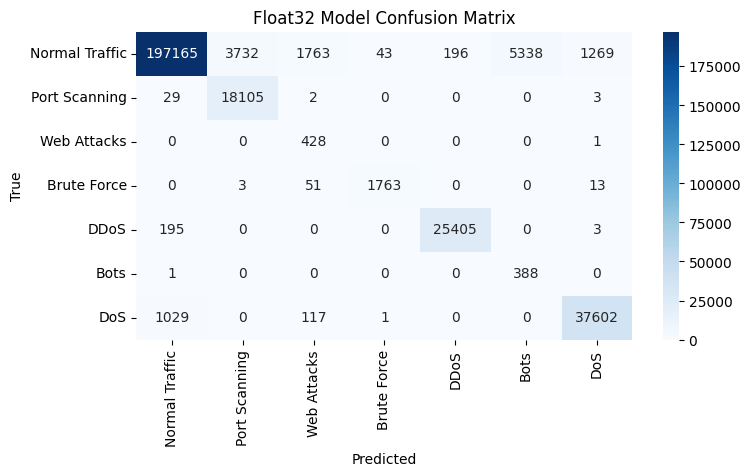

Accuracy: 0.9532013100510784
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.94      0.97    209506
 Port Scanning       0.83      1.00      0.91     18139
   Web Attacks       0.18      1.00      0.31       429
   Brute Force       0.98      0.96      0.97      1830
          DDoS       0.99      0.99      0.99     25603
          Bots       0.07      1.00      0.13       389
           DoS       0.97      0.97      0.97     38749

      accuracy                           0.95    294645
     macro avg       0.72      0.98      0.75    294645
  weighted avg       0.98      0.95      0.96    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 83885 (98.53% of Malware Identified)
True Negatives (Benign predicted as Benign): 197165 (94.11% of Benign Identified)
False Positives (Benign predicted as 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


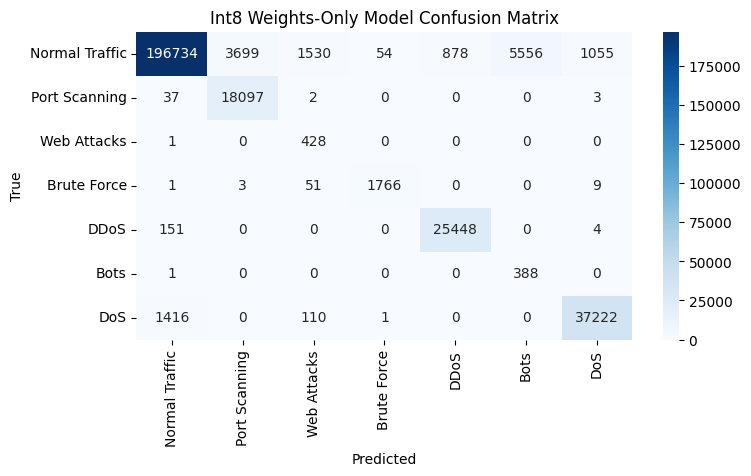

Accuracy: 0.9505778139795347
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.94      0.96    209506
 Port Scanning       0.83      1.00      0.91     18139
   Web Attacks       0.20      1.00      0.34       429
   Brute Force       0.97      0.97      0.97      1830
          DDoS       0.97      0.99      0.98     25603
          Bots       0.07      1.00      0.12       389
           DoS       0.97      0.96      0.97     38749

      accuracy                           0.95    294645
     macro avg       0.71      0.98      0.75    294645
  weighted avg       0.97      0.95      0.96    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 83532 (98.11% of Malware Identified)
True Negatives (Benign predicted as Benign): 196734 (93.90% of Benign Identified)
False Positives (Benign predicted as 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


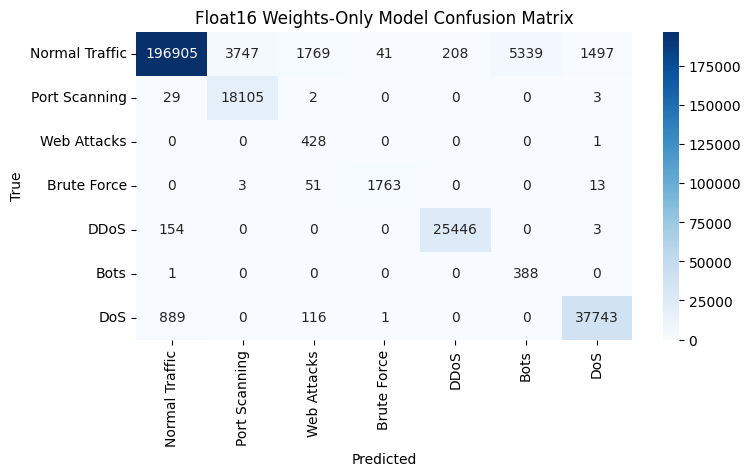

Accuracy: 0.9529365847036264
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.94      0.97    209506
 Port Scanning       0.83      1.00      0.91     18139
   Web Attacks       0.18      1.00      0.31       429
   Brute Force       0.98      0.96      0.97      1830
          DDoS       0.99      0.99      0.99     25603
          Bots       0.07      1.00      0.13       389
           DoS       0.96      0.97      0.97     38749

      accuracy                           0.95    294645
     macro avg       0.71      0.98      0.75    294645
  weighted avg       0.98      0.95      0.96    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 84066 (98.74% of Malware Identified)
True Negatives (Benign predicted as Benign): 196905 (93.99% of Benign Identified)
False Positives (Benign predicted as 

In [ ]:
# -----------------------------
# --- Evaluate Quant Models ---
# -----------------------------

# List of TFLite models, with FP32 activations
tflite_models = [
    {"model": quantModel_f32, "name": "Float32 Model"},
    {"model": quantModel_fp16_weights, "name": "Float16 Weights-Only Model"}
    {"model": quantModel_int8_weights, "name": "Int8 Weights-Only Model"},

]

# --- Evaluate the models ---
for m in tflite_models: # Loop through all the models

    tflite_model = m["model"]
    model_name = m["name"]

    print(f"\n --- Evaluating: {model_name} ---")

    # Loads the TFLite model and get it ready to make predictions
    interpreter = tf.lite.Interpreter(model_content=tflite_model) # Create interpreter object that will read and run the TFLite model
    interpreter.allocate_tensors()                                # Make the interpreter allocate memory
    input_details = interpreter.get_input_details()               # Get expected shape and data type of the data the model needs to evaluate (built-in method)
    output_details = interpreter.get_output_details()             # Get the shape and data type the model will need to produce the results in


    # --- Get model predictions for test sample ---

    y_pred_probs = []

    for i in range(len(X_test)): # Interpreter object does not have a built-in .evaluate() method like the Keras Model object does, therefore need to go through every sample manually

        input_data = np.expand_dims(X_test[i], axis=0).astype(input_details[0]['dtype'])  # Add an extra dimension to the input (model expects input in batches, even if the batch size is 1) so the data type matches what the model expects
        interpreter.set_tensor(input_details[0]['index'], input_data)                     # Feed a single sample of input data into the TFLite interpreter
        interpreter.invoke()                                                              # Tell the interpreter to run the model on the input data
        output_data = interpreter.get_tensor(output_details[0]['index'])                  # Get the output from the model
        y_pred_probs.append(output_data[0])                                               # Add the raw output to the y_pred_probs list

    y_pred_probs = np.array(y_pred_probs)     # Convert the list to a single NumPy array
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class label for each sample


    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    # Create confusion matrix plot
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(cm[normal_traffic, :])
        benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        tn = benign_identified_correctly
        fp = benign_misclassified

        total_malware = len(X_test) - total_benign
        print(f"Total Mal: {len(X_test) - total_benign} & {np.sum(cm) - np.sum(cm[normal_traffic, :])}")

        malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)): # For a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
            if i != normal_traffic:  # Skip the normal traffic rows in the cm ([0:i])
                malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        fn = malware_misclassified
        tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---

        print("\nTP, TN, FP, FN for Malware vs Benign:")

        print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = cm[i, i]
                total_in_class = np.sum(cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Calculate Performance Metrics ---

        #Accuracy
        accuracy = (tp + tn)/(tp + tn + fp + fn)
        # Precision (for malware class)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")




# Full integer Quantisation of the model (TinyCNN Baseline)

In [ ]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import numpy as np
import os

In [ ]:
def representative_dataset_gen():
    # Get class distribution
    class_types= np.unique(y_train) # Get all the unique attack classes in y_train and how many samples each class has
    class_indices = [np.where(y_train == c)[0] for c in class_types] # For a class,'c', get all the indices of the samples in X-train that belong to that class

    # Pick equal number of samples per class
    selected_indices = []
    rng = np.random.default_rng(seed=1) # Random seed for reproducability
    for indices in class_indices:
        selected_indices.extend(rng.choice(indices, 50, replace=False))

    np.random.shuffle(selected_indices)
    representative_indices = selected_indices

    # Yield chosen samples
    for i in representative_indices:
        yield [np.expand_dims(X_train[i].astype(np.float32), 0)]


In [ ]:
# --- Full Integer Model Quantization ---

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type  = tf.int8
converter.inference_output_type = tf.int8
quantModel_int8 = converter.convert()

# --- Save model ---
with open(model_name_prefix + '_int8_full.tflite', 'wb') as f:
    f.write(quantModel_int8)


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmph4yswqcb/assets


INFO:tensorflow:Assets written to: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmph4yswqcb/assets


Saved artifact at '/var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmph4yswqcb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  4730129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730129104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6110778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4401215248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730310864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730318928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4730319312: TensorSpec(shap

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1757069751.403269 6359028 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757069751.403278 6359028 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-05 12:55:51.403375: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmph4yswqcb
2025-09-05 12:55:51.403903: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-05 12:55:51.403908: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/j_/5tg7bs_11dd5dp51xgcdjp340000gn/T/tmph4yswqcb
2025-09-05 12:55:51.409659: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-05 12:55:51.

Evaluation of quant models

In [ ]:
# -- Imports ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf


--- Evaluating: Int8 Quantized Model ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


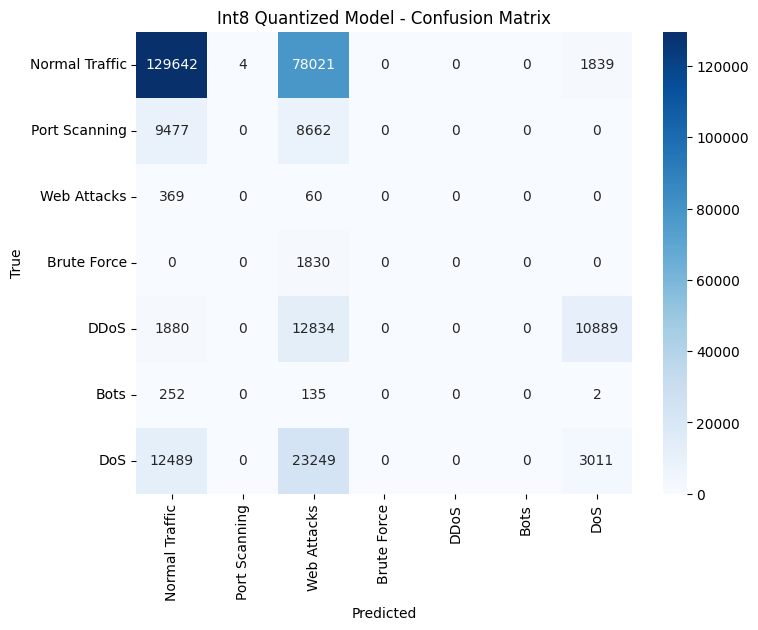

Accuracy: 0.45041660303076586
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.84      0.62      0.71    209506
 Port Scanning       0.00      0.00      0.00     18139
   Web Attacks       0.00      0.14      0.00       429
   Brute Force       0.00      0.00      0.00      1830
          DDoS       0.00      0.00      0.00     25603
          Bots       0.00      0.00      0.00       389
           DoS       0.19      0.08      0.11     38749

      accuracy                           0.45    294645
     macro avg       0.15      0.12      0.12    294645
  weighted avg       0.62      0.45      0.52    294645

Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 60672 (71.26% of Malware Identified)
True Negatives (Benign predicted as Benign): 129642 (61.88% of Benign Identified)
False Positives (Benign predicted as Malware): 79864 (38.12% 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
# --- List of TFLite models ---
tflite_models = [
    {"model": quantModel_int8, "name": "Int8 Quantized Model", "filename": "_int8_full.tflite"}, # Added filename
]

# --- Evaluate full INT8 model ---
for m in tflite_models:

    the_model = m["model"]
    model_name = m["name"]
    print(f"\n--- Evaluating: {model_name} ---")

    interpreter = tf.lite.Interpreter(model_content=the_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    in_scale,  in_zp  = input_details['quantization']
    out_scale, out_zp = output_details['quantization']

    # Get predictions

    y_pred_probs = []

    for i in range(len(X_test)):
      sample_input = np.expand_dims(X_test[i], axis=0).astype(input_details['dtype'])

      # Quantise input correctly for int8 models
      if input_details['dtype'] == np.int8:
          quant_sample_input = np.round(sample_input / in_scale + in_zp).astype(np.int8)

      # Run sample through model
      interpreter.set_tensor(input_details['index'], quant_sample_input)
      interpreter.invoke()
      quant_sample_output = interpreter.get_tensor(output_details['index'])

      # Dequantise outputs back to float
      if output_details['dtype'] == np.int8:
          sample_output = (quant_sample_output.astype(np.float32) - out_zp) * out_scale

      y_pred_probs.append(sample_output[0])

    # Get final predicted values for each sample
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)


    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    # Plot CM
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(cm[normal_traffic, :])
        benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        tn = benign_identified_correctly
        fp = benign_misclassified

        total_malware = len(X_test) - total_benign
        malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        fn = malware_misclassified
        tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---

        print("\nTP, TN, FP, FN for Malware vs Benign:")

        print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = cm[i, i]
                total_in_class = np.sum(cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

    # ---- Performance Metrics ---

    #Accuracy
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    # Precision (for malware class)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall / Sensitivity (for malware class)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # False Positive Rate (FPR)
    fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
    # False Negative Rate (FNR)
    fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

    print("\n--- Malware vs Benign Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Malware): {precision:.4f}")
    print(f"Recall / Sensitivity (Malware): {recall:.4f}")
    print(f"F1-Score (Malware): {f1_score:.4f}")
    print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
    print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

